# Tiny Benchmark

In [1]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); 
# Pkg.instantiate(); 

  Activating project at `~/Documents/GitHub/jjtest`


This notebook is used to test small performance differences in **RxInfer.jl** during the development process for a very simple model. This benchmark does not represent the whole range of possible regressions but it is quick and easy to execute.

In [2]:
using RxInfer, BenchmarkTools, Random, Plots,Distributions
# using BenchmarkTools, Random, Plots,Distributions

## Synthetic dataset

In [3]:
seed = 123

rng = MersenneTwister(seed)

v = 100.0

n = 10

hidden     = collect(1:n)
data       = hidden + rand(rng, Normal(0.0, sqrt(v)), n);
datastream = from(data) |> map(NamedTuple{(:y, ), Tuple{Float64}}, (d) -> (y = d, ));

## Smoothing

In [4]:
@model function smoothing(n; c::ConstVariable, v::ConstVariable)
    
    x_prior ~ Normal(mean = 0.0, variance = 10000.0) 

    x = randomvar(n)
    y = datavar(Float64, n)
    
    x_prev = x_prior
    
    for i in 1:n
        x[i] ~ x_prev + c
        y[i] ~ Normal(mean = x[i], variance = v)
        x_prev = x[i]
    end
    
    return x, y
end

In [5]:
function run_smoothing(data, n, v)
    return inference(
        model = smoothing(n, c = 1.0, v = v), 
        data  = (y = data[1:end], ), 
        returnvars = KeepLast(),
        free_energy = false,
        iterations = 20,
        allow_failed = true
        # postprocess = UnpackMarginalPostprocess()
    )
end

run_smoothing (generic function with 1 method)

In [6]:
result_smoothing = run_smoothing(data, n, v)

error_type = InterruptException()


Inference results:
  Posteriors       | available for (x_prior, x)


In [7]:
result_smoothing.posteriors

Dict{Symbol, Any} with 2 entries:
  :x_prior => NormalWeightedMeanPrecision{Float64}(xi=0.476419, w=0.1001)
  :x       => NormalWeightedMeanPrecision{Float64}[NormalWeightedMeanPrecision{…

In [8]:
result_smoothing.posteriors[:x]

10-element Vector{NormalWeightedMeanPrecision{Float64}}:
 NormalWeightedMeanPrecision{Float64}(xi=0.5765193552030099, w=0.1001)
 NormalWeightedMeanPrecision{Float64}(xi=0.6766193552030099, w=0.1001)
 NormalWeightedMeanPrecision{Float64}(xi=0.7767193552030098, w=0.10010000000000001)
 NormalWeightedMeanPrecision{Float64}(xi=0.8768193552030097, w=0.10010000000000002)
 NormalWeightedMeanPrecision{Float64}(xi=0.9769193552030095, w=0.10010000000000001)
 NormalWeightedMeanPrecision{Float64}(xi=1.0770193552030096, w=0.10010000000000001)
 NormalWeightedMeanPrecision{Float64}(xi=1.1771193552030097, w=0.1001)
 NormalWeightedMeanPrecision{Float64}(xi=1.2772193552030096, w=0.1001)
 NormalWeightedMeanPrecision{Float64}(xi=1.3773193552030096, w=0.10009999999999998)
 NormalWeightedMeanPrecision{Float64}(xi=1.4774193552030097, w=0.10009999999999998)

In [9]:
result_smoothing

Inference results:
  Posteriors       | available for (x_prior, x)


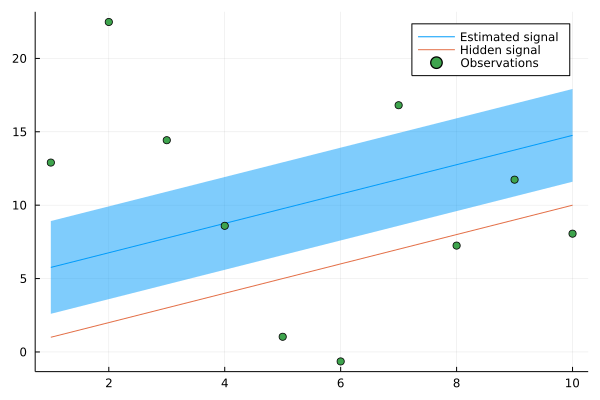

In [10]:
let 
    results = result_smoothing.posteriors[:x]
    subrange = 1:10
    
    m = mean.(results)[subrange]
    s = std.(results)[subrange]
    
    p = plot()
    
    p = plot!(subrange, m, ribbon = s, label = "Estimated signal")
    p = plot!(subrange, hidden[subrange], label = "Hidden signal")
    p = scatter!(subrange, data[subrange], label = "Observations")
    
    plot(p)
end

# Benchmarks